In [27]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [28]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

C:\Users\28472\Anaconda\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [29]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

C:\Users\28472\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [30]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\28472\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


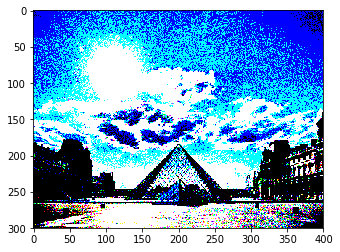

In [31]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [32]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [33]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    
    return J_content

In [34]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

In [35]:
def compute_style_cost(model, STYLE_LAYERS):

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [36]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [37]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    
    return J_style_layer

In [38]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))
        
    return GA

In [39]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [40]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style
    
    return J

In [41]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [42]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [43]:
def model_nn(sess, input_image, num_iterations = 200):

    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
        
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [44]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5045719000.0
content cost = 7891.3975
style cost = 126141010.0
Iteration 20 :
total cost = 932442430.0
content cost = 15392.261
style cost = 23307212.0
Iteration 40 :
total cost = 479386430.0
content cost = 16947.445
style cost = 11980424.0
Iteration 60 :
total cost = 312793400.0
content cost = 17602.412
style cost = 7815434.5
Iteration 80 :
total cost = 230093810.0
content cost = 17927.615
style cost = 5747863.0
Iteration 100 :
total cost = 181518990.0
content cost = 18142.104
style cost = 4533439.0
Iteration 120 :
total cost = 149529780.0
content cost = 18337.352
style cost = 3733660.0
Iteration 140 :
total cost = 126746390.0
content cost = 18519.764
style cost = 3164029.8
Iteration 160 :
total cost = 109601976.0
content cost = 18650.518
style cost = 2735386.8
Iteration 180 :
total cost = 96356024.0
content cost = 18771.28
style cost = 2404207.8


array([[[[ -28.118885  ,   -7.1374893 ,   68.42722   ],
         [ -42.1639    ,   -9.136788  ,   77.95909   ],
         [  -9.659305  ,  -10.061543  ,   65.45576   ],
         ...,
         [  15.758187  ,  -24.733856  ,   32.652397  ],
         [   4.5321374 ,  -21.920591  ,   32.5608    ],
         [  -0.30137777,  -28.293673  ,   55.12149   ]],

        [[ -37.49646   ,   -9.12599   ,   34.635227  ],
         [ -50.64537   ,   -8.482327  ,   28.383312  ],
         [ -25.157866  ,   -0.61512613,   20.864603  ],
         ...,
         [  19.160421  ,  -21.639431  ,   21.633724  ],
         [  11.968635  ,  -44.87286   ,   51.99724   ],
         [   7.2509503 ,  -26.514143  ,   52.047268  ]],

        [[ -40.14536   ,    2.7795267 ,   54.026775  ],
         [ -51.582718  ,  -21.221073  ,    9.191757  ],
         [ -39.571457  ,    5.8993826 ,  -11.59778   ],
         ...,
         [  15.423256  ,   -8.840211  ,    4.6540375 ],
         [   8.735886  ,  -32.98393   ,   38.99729   ],
  

**Some examples of neural style transfer**

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

<img src="images/circle_abstract.png" style="width:750px;height:300px;">